In [1]:
%pylab inline

import numpy as np
import pymc3 as pm
from scipy.special import expit
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


items = 400
k_mean = -7
k_sigma = 0.5
noise_sigma = 0.15
trials_lambda = 0.02
samples_per_item = 3

# drawing values at an item level
item_conversion_rates = np.random.normal(loc=k_mean, scale=k_sigma, size=items)

# values at a sample level
labels = np.repeat(np.arange(items), samples_per_item)
sample_conversion_rates = np.repeat(item_conversion_rates, samples_per_item)

trials = np.random.geometric(p=trials_lambda, size=samples_per_item * items)

adjusted_conversion_rate = expit(sample_conversion_rates)
conversions = np.random.binomial(trials, adjusted_conversion_rate)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


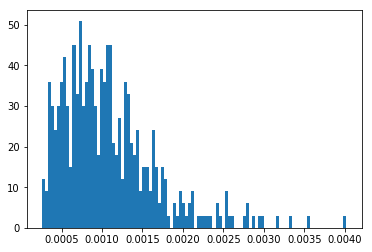

In [2]:
plt.hist(adjusted_conversion_rate, 100);

In [3]:
with pm.Model() as indexed_model:
    # Priors for unknown model parameters
    k_mu = pm.Normal('c_mu', mu=0., sd=10.)
    c_sigma = pm.HalfNormal('c_sigma', sd=5.)

    # Matt trick
    k_step = pm.Normal('k_step', mu=0, sd=1, shape=items)
    k = k_mu + k_step * c_sigma

    # Modeling conversions
    k_indexed = k[labels]
    conv_rate = pm.math.invlogit(k_indexed)

    # Likelihood
    product_conversions = pm.Binomial('product_conversion',
                                         n=trials,
                                         p=conv_rate,
                                         observed=conversions)

    indexed_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k_step, c_sigma_log__, c_mu]
 47%|████▋     | 931/2000 [00:09<00:10, 99.36it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '30262' (I am process '30263')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
 48%|████▊     | 953/2000 [00:09<00:10, 100.60it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '30262' (I am process '30264')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir

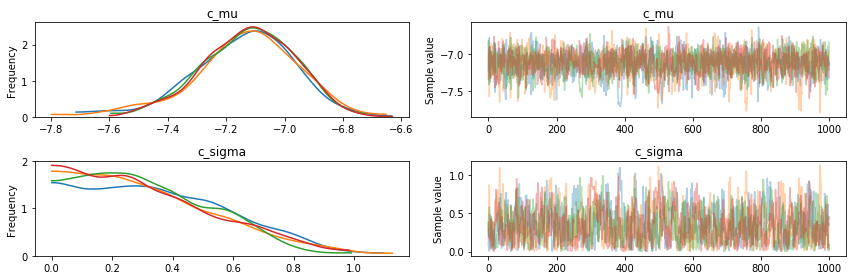

In [4]:
pm.traceplot(indexed_trace, varnames=['c_mu', 'c_sigma']);

In [5]:
indexed_trace.varnames

['c_mu', 'c_sigma_log__', 'k_step', 'c_sigma']

In [6]:
indexed_trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

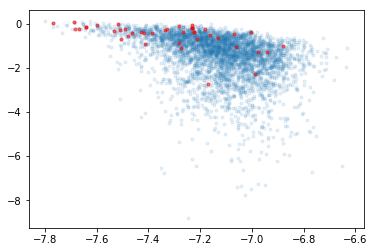

In [7]:
diverge = indexed_trace.get_sampler_stats('diverging', combine=True)
plt.scatter(indexed_trace['c_mu'], indexed_trace['c_sigma_log__'],
            marker='.', alpha=0.1)
plt.scatter(indexed_trace['c_mu'][diverge], indexed_trace['c_sigma_log__'][diverge],
            marker='.', alpha=0.5, color='r')
plt.show()

In [8]:
with pm.Model():
    # Priors for unknown model parameters
    k_mu = pm.Normal('c_mu', mu=0., sd=10.)
    c_sigma = pm.HalfNormal('c_sigma', sd=5., transform=None)

    # Matt trick
    k_step = pm.Normal('k_step', mu=0, sd=1, shape=items)
    k = k_mu + k_step * c_sigma

    # Modeling conversions
    k_indexed = k[labels]
    conv_rate = pm.math.invlogit(k_indexed)

    # Likelihood
    product_conversions = pm.Binomial('product_conversion',
                                         n=trials,
                                         p=conv_rate,
                                         observed=conversions)

    indexed_trace_ = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k_step, c_sigma, c_mu]
100%|██████████| 2000/2000 [00:11<00:00, 179.76it/s]
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maxim

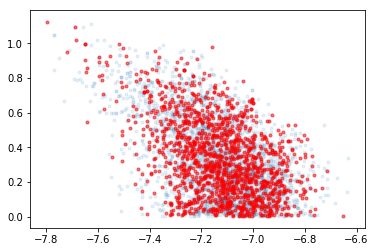

In [9]:
diverge = indexed_trace_.get_sampler_stats('diverging', combine=True)
mu_post = indexed_trace['c_mu']
sigma_post = indexed_trace['c_sigma']
plt.scatter(mu_post, sigma_post,
            marker='.', alpha=0.1)
plt.scatter(mu_post[diverge], sigma_post[diverge],
            marker='.', alpha=0.5, color='r')
plt.show()